# **PHISHING EMAIL DETECTOR MODEL COMPARISON**
---



In this notebook we compare different supervized classification models (SVM, KNN, DT, RF, LR, XGB, MultiNB). We compare their training time and performance. We improve the one with highest performance and least training time further using hyperparameters. 

**Loading, data explorating and preprocessing**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from time import perf_counter
import warnings
warnings.filterwarnings(action='ignore')
df = pd.read_csv('./spam_ham_dataset.csv')

**Cleaning Data**

In [ ]:
from nltk.tokenize import RegexpTokenizer

def clean_str(string, reg = RegexpTokenizer(r'[a-z]+')):
    # Clean a string with RegexpTokenizer
    string = string.lower()
    tokens = reg.tokenize(string)
    return " ".join(tokens)

print('Before cleaning:')
df['text'][0]



Before cleaning:


"Subject: enron methanol ; meter # : 988291\r\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily volume { presently zero } to reflect daily\r\nactivity you can obtain from gas control .\r\nthis change is needed asap for economics purposes ."

In [ ]:
print('After cleaning:')
clean_str(df['text'][0])

After cleaning:


'subject enron methanol meter this is a follow up to the note i gave you on monday preliminary flow data provided by daren please override pop s daily volume presently zero to reflect daily activity you can obtain from gas control this change is needed asap for economics purposes'

In [ ]:
# Create a new column with the cleaned messages
df['text_clean'] = df['text'].apply(lambda string: clean_str(string))

# Display the result
df.head()

,Unnamed: 0,label,text,label_num,text_clean
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,subject enron methanol meter this is a follow ...
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,subject hpl nom for january see attached file ...
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,subject neon retreat ho ho ho we re around to ...
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,subject photoshop windows office cheap main tr...
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,subject re indian springs this deal is to book...


In [ ]:
# Convert a collection of text documents to a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(df.text_clean)

# Get the categories
y = df.label

In [ ]:
# Split arrays or matrices into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

**Model comparison**

In [ ]:
models = {
    "Random Forest": {"model":RandomForestClassifier(), "perf":0},
    "Gradient Boosting": {"model":GradientBoostingClassifier(), "perf":0},
    "XGBoost": {"model":XGBClassifier(eval_metric='mlogloss'), "perf":0},
    "MultinomialNB": {"model":MultinomialNB(), "perf":0},
    "Logistic Regr.": {"model":LogisticRegression(), "perf":0},
    "KNN": {"model":KNeighborsClassifier(), "perf":0},
    "Decision Tree": {"model":DecisionTreeClassifier(), "perf":0},
    "SVM (Linear)": {"model":LinearSVC(), "perf":0},
    "SVM (RBF)": {"model":SVC(), "perf":0}
}

for name, model in models.items():
    start = perf_counter()
    model['model'].fit(X_train, y_train)
    duration = perf_counter() - start
    duration = round(duration,2)
    model["perf"] = duration

In [ ]:
models_acc = []
for name, model in models.items():
    models_acc.append([name, model["model"].score(X_test, y_test),model["perf"]])

In [ ]:
df_acc = pd.DataFrame(models_acc)
df_acc.columns = ['Model', 'Accuracy w/o scaling', 'Training time (sec)']
df_acc.sort_values(by = 'Accuracy w/o scaling', ascending = False, inplace=True)
df_acc.reset_index(drop = True, inplace=True)
df_acc

,Model,Accuracy w/o scaling,Training time (sec)
0,Random Forest,0.974879,4.94
1,Logistic Regr.,0.973913,1.36
2,MultinomialNB,0.971981,0.02
3,XGBoost,0.967150,6.19
4,SVM (Linear),0.964251,0.20
5,Gradient Boosting,0.960386,18.17
6,Decision Tree,0.959420,0.78
7,SVM (RBF),0.957488,5.40
8,KNN,0.871498,0.01


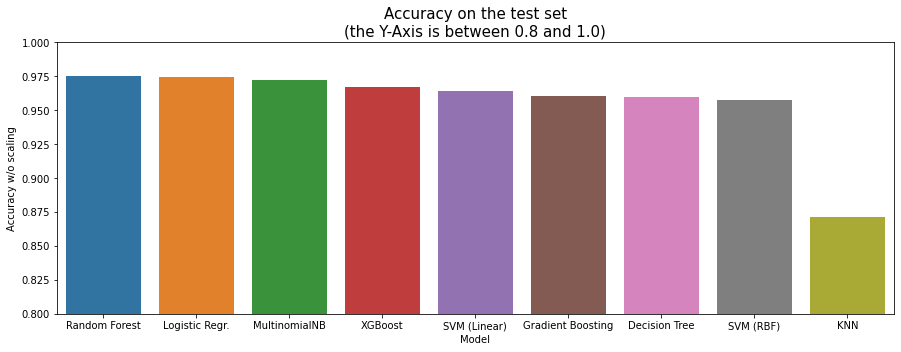

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'Model', y = 'Accuracy w/o scaling', data = df_acc)
plt.title('Accuracy on the test set\n(the Y-Axis is between 0.8 and 1.0)', fontsize = 15)
plt.ylim(0.8,1)
plt.show()

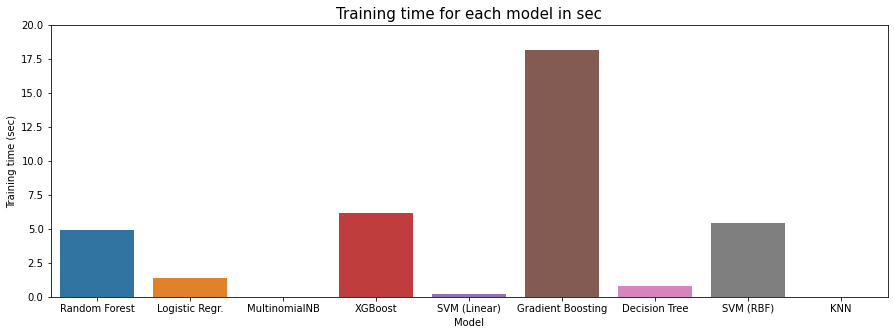

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'Model', y = 'Training time (sec)', data = df_acc)
plt.title('Training time for each model in sec', fontsize = 15)
plt.ylim(0,20)
plt.show()

***XGBoosting gives the best result on the test set. Nevertheless, MultinomialNB is nearly as good, but is very fast (0.2 sec vs 5.1 sec). In the following part, we'll choose the MultinomialNB and try various hyperparameters to optimize it.***

Hyperparameter selection for MultinomialNB

In [ ]:
# Find the best hyperparameter with GridSearchCV
# Exhaustive search over specified parameter values for an estimator.
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
parameters = {"alpha": [0.2,1,2,5,10], "fit_prior": [True, False]}

grid = GridSearchCV(MultinomialNB(), param_grid=parameters)
grid.fit(X_train,y_train)

# Create a DataFrame with the best Hyperparameters
pd.DataFrame(grid.cv_results_)[['params','mean_test_score']]\
                               .sort_values(by="mean_test_score", ascending=False)

,params,mean_test_score
0,"{'alpha': 0.2, 'fit_prior': True}",0.981384
1,"{'alpha': 0.2, 'fit_prior': False}",0.981142
3,"{'alpha': 1, 'fit_prior': False}",0.979690
2,"{'alpha': 1, 'fit_prior': True}",0.977999
5,"{'alpha': 2, 'fit_prior': False}",0.971713
4,"{'alpha': 2, 'fit_prior': True}",0.967602
7,"{'alpha': 5, 'fit_prior': False}",0.938591
6,"{'alpha': 5, 'fit_prior': True}",0.930854
9,"{'alpha': 10, 'fit_prior': False}",0.886127
8,"{'alpha': 10, 'fit_prior': True}",0.875971


In [ ]:
# Display the best hyperparameters
grid.best_params_

{'alpha': 0.2, 'fit_prior': True}

**The MultinomialNB Model**

In [ ]:
# Create the model with the best hyperparameters
from sklearn.naive_bayes import MultinomialNB
alpha, fit_prior = grid.best_params_['alpha'], grid.best_params_['fit_prior']
model = MultinomialNB(alpha = alpha)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score
print("Accuracy:", round(accuracy_score(y_test,y_pred),3)*100)

Accuracy: 97.5
